In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import percentileofscore, zscore
import ta
import os
from typing import List, Tuple
from models import *

In [2]:
from backtest_optimizer.main import (
    ParameterOptimizer,
)

/home/alemish/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
file_path = 'BTCUSDT.csv'
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

/tmp/ipykernel_20555/2384937232.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [5]:
sequence_length = 100

In [6]:
def mark_extremes_advanced(prices: List[float],
                           threshold_abs: float = 0.0,
                           threshold_pct: float = 0.03,
                           use_pct: bool = True,
                           dynamic_threshold: bool = False,
                           vol_window: int = 10,
                           vol_multiplier: float = 1.0,
                           confirmation_period: int = 1) -> List[Tuple[int, str]]:
    """
    Identify turning points (peaks and troughs) in a price series using an advanced zigzag approach.
    
    In this version, a turning point is detected only after a reversal condition is confirmed
    for a number of consecutive bars (confirmation_period). In addition, the threshold for a reversal
    can be based on either a fixed percentage/absolute level or (optionally) be dynamically adjusted 
    based on recent volatility.
    
    Parameters:
        prices (List[float]): List of price values.
        threshold_abs (float): Fixed absolute threshold (if use_pct is False).
        threshold_pct (float): Percentage threshold (e.g. 0.03 for 3%) used if use_pct is True.
        use_pct (bool): If True, the base threshold is computed as threshold_pct * current_price.
        dynamic_threshold (bool): If True, adjust the threshold based on recent volatility.
        vol_window (int): Number of bars to compute volatility if dynamic_threshold is True.
        vol_multiplier (float): Multiplier for volatility to form a dynamic threshold.
        confirmation_period (int): Number of consecutive bars that must confirm a reversal before marking it.
    
    Returns:
        List[Tuple[int, str]]: A list of tuples where each tuple is (index, type) and type is either 'peak' or 'trough'.
    """
    if not prices:
        return []
    
    turning_points: List[Tuple[int, str]] = []
    
    # Initialize extremes with the first price.
    last_min = prices[0]
    last_max = prices[0]
    last_min_idx = 0
    last_max_idx = 0

    # Trend indicator: True means an uptrend (so the last extreme was a minimum)
    # False means a downtrend (last extreme was a maximum). None means not yet established.
    trend = None

    i = 1
    n = len(prices)
    
    while i < n:
        price = prices[i]
        
        if dynamic_threshold:
            if i < vol_window:
                i += 1
                continue
            recent_changes = np.diff(prices[i-vol_window:i+1])
            volatility = np.std(recent_changes)
            dynamic_thresh = vol_multiplier * volatility
            threshold = max(threshold_abs, dynamic_thresh)
        else:
            threshold = threshold_abs if not use_pct else threshold_pct * prices[i]
        # --- Update current extremes ---
        if price > last_max:
            last_max = price
            last_max_idx = i
        if price < last_min:
            last_min = price
            last_min_idx = i
        # --- Establish the initial trend if not set ---
        if trend is None:
            if last_max - prices[0] > threshold:
                trend = True   # Uptrend is established (price rose from the first bar)
            elif prices[0] - last_min > threshold:
                trend = False  # Downtrend is established
            # Else, trend remains undefined.
        # --- Check for reversal conditions with confirmation ---
        # In an uptrend, a sufficient drop from the last maximum signals a potential reversal.
        if trend is True and (last_max - price > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if last_max - prices[j] <= threshold:
                    confirm = False
                    break
            if confirm:
                # In an uptrend, a drop signals that the previous maximum is a peak.
                turning_points.append((last_max_idx, 'peak'))
                # Reset the minimum using the current price.
                last_min = prices[i]
                last_min_idx = i
                trend = False
                i += confirmation_period  # Skip confirmation period.
                continue
        
        # In a downtrend, a sufficient rise from the last minimum signals a potential reversal.
        if trend is False and (price - last_min > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if prices[j] - last_min <= threshold:
                    confirm = False
                    break
            if confirm:
                turning_points.append((last_min_idx, 'trough'))
                # Reset the maximum using the current price.
                last_max = prices[i]
                last_max_idx = i
                trend = True
                i += confirmation_period
                continue
        
        i += 1

    # Always mark the final point as a turning point if it wasn’t already included.
    if not turning_points or turning_points[-1][0] != n - 1:
        # For the final point, we decide its type based on the current trend.
        final_type = 'trough' if trend else 'peak'
        turning_points.append((n - 1, final_type))
    
    return turning_points

def expand_region(prices: List[float],
                  extreme_index: int,
                  extreme_type: str,
                  region_tolerance_pct: float) -> Tuple[int, int]:
    """
    Given an extreme (turning point) at extreme_index with a given type ('peak' or 'trough'),
    expand outward to mark the region where the price remains close to the extreme value.
    
    For a 'peak', we include contiguous indices where the price is within (1 - region_tolerance_pct) 
    of the peak value. For a 'trough', we include indices where the price is within (1 + region_tolerance_pct)
    of the trough value.
    
    Parameters:
        prices (List[float]): The price series.
        extreme_index (int): The index of the turning point.
        extreme_type (str): Either 'peak' or 'trough'.
        region_tolerance_pct (float): Tolerance as a fraction (e.g., 0.01 for 1%).
    
    Returns:
        Tuple[int, int]: A tuple (start_index, end_index) defining the region boundaries.
    """
    extreme_value = prices[extreme_index]
    start = extreme_index
    end = extreme_index
    n = len(prices)
    
    if extreme_type == 'peak':
        # Expand left as long as the price is within region_tolerance_pct of the peak.
        while start > 0 and prices[start - 1] >= extreme_value * (1 - region_tolerance_pct):
            start -= 1
        # Expand right similarly.
        while end < n - 1 and prices[end + 1] >= extreme_value * (1 - region_tolerance_pct):
            end += 1
    elif extreme_type == 'trough':
        while start > 0 and prices[start - 1] <= extreme_value * (1 + region_tolerance_pct):
            start -= 1
        while end < n - 1 and prices[end + 1] <= extreme_value * (1 + region_tolerance_pct):
            end += 1
    else:
        raise ValueError("extreme_type must be either 'peak' or 'trough'.")
    
    return start, end

def mark_extreme_regions(prices: List[float],
                         threshold_abs: float = 0.0,
                         threshold_pct: float = 0.03,
                         use_pct: bool = True,
                         dynamic_threshold: bool = False,
                         vol_window: int = 10,
                         vol_multiplier: float = 1.0,
                         confirmation_period: int = 1,
                         region_tolerance_pct: float = 0.01) -> List[Tuple[int, int, str]]:
    """
    First detect turning points using an advanced zigzag algorithm, then expand each turning point
    into a region where the price remains near the extreme value.
    
    Returns a list of tuples (region_start_index, region_end_index, type), where type is 'peak' or 'trough'.
    """
    # Detect turning points.
    turning_points = mark_extremes_advanced(prices, threshold_abs, threshold_pct, use_pct,
                                            dynamic_threshold, vol_window, vol_multiplier, confirmation_period)
    regions = []
    for idx, t_type in turning_points:
        start, end = expand_region(prices, idx, t_type, region_tolerance_pct)
        regions.append((start, end, t_type))
    return regions

def detect_anomalies_agg_returns(df, L=10, rolling_window=50, threshold=3, method="sum"):
    returns = df["close"].pct_change().fillna(0)
    if method == "sum":
        S = returns.rolling(window=L).sum()
    else:
        S = returns.rolling(window=L).mean()
    S = S.dropna()
    med = S.rolling(window=rolling_window, center=True).median()
    mad = S.rolling(window=rolling_window, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    robust_z = (S - med) / (1.4826 * mad)
    agg_anomalies = S.index[np.abs(robust_z) > threshold]
    return agg_anomalies


In [7]:
def detect_anomalies(mse, num_std):
    """Detect anomalies in test data using thresholding."""
    threshold = np.mean(mse) + num_std*np.std(mse)
    #print("Threshold = ", np.round(threshold, 2))
    anomalies = np.where(mse > np.round(threshold, 2))[0]
    return anomalies

def deviation_from_mean(data, value):
    # z_scores = zscore(data)
    deviation = (value - np.mean(data)) / np.std(data)
    return deviation

def simulate_trading_std(
    model_name,
    price_data,
    scaled_prices,
    predicted_prices,
    ma_data,
    rsi_data,
    scores,
    rolling_anomalies,
    num_std,
    max_entries,
    exit_val,
    distr_len=99,
    num_std_exit=1,
    rsi_entry=[40, 60],
    rsi_exit=[60, 40],
    print_trades=False,
    comission_rate=0.0002,
):

    price_array = price_data.to_numpy(dtype=np.float64)
    ma_array = ma_data.to_numpy(dtype=np.float64)
    rsi_data = rsi_data.to_numpy(dtype=np.float64)
    anomalies_array = np.asarray(rolling_anomalies, dtype=bool)

    index_array = price_data.index.to_numpy() 

    n = len(price_array)
    if len(rsi_data) != n or len(anomalies_array) != n:
        raise ValueError("price_data, ma_data, and rolling_anomalies must have the same length.")

    rolling_std_series = price_data.rolling(distr_len, min_periods=1).std()
    rolling_std = rolling_std_series.values
    
    initial_capital = 1.0
    capital = initial_capital
    # capital_history_array = np.full(n, np.nan, dtype=np.float64)
    # capital_history_array[0] = capital
    profit_array = np.full(n, np.nan, dtype=np.float64)

    open_trades = []
    trade_entries = set()  
    closed_trades = []

    base_price = None
    k = 0
    base_trade_type = None

    for i in range(n):
        timestamp = index_array[i] 
        current_price = price_array[i]
        current_ma = ma_array[i]
        current_rsi = rsi_data[i]

        local_std_exit = rolling_std[i]

        daily_profit = 0.0
        if open_trades:
            trades_to_close = []
            
            for trade in open_trades:
                trade_type = trade["type"]
                entry_price = trade["entry_price"]

                if exit_val == "rsi":
                    if (trade_type == "buy"  and current_rsi >= rsi_exit[0]) or \
                       (trade_type == "sell" and current_rsi <= rsi_exit[1]):
                        trades_to_close.append(trade)
                        continue
                if exit_val == "ma":
                    if (trade_type == "buy"  and current_price >= current_ma) or \
                       (trade_type == "sell" and current_price <= current_ma):
                        trades_to_close.append(trade)
                        continue

                if trade_type == "buy":
                    if current_price >= (entry_price + local_std_exit * num_std_exit):
                        trades_to_close.append(trade)
                elif trade_type == "sell":
                    if current_price <= (entry_price - local_std_exit * num_std_exit):
                        trades_to_close.append(trade)


            for trade in trades_to_close:
                trade_type = trade["type"]
                entry_price = trade["entry_price"]
                exit_price = current_price
                trade_volume = trade["volume"]
            
                if trade_type == "buy":
                    profit = (exit_price - entry_price) * (trade_volume / entry_price)
                else:  
                    profit = (entry_price - exit_price) * (trade_volume / entry_price)

                profit -= (trade_volume * comission_rate)
                capital += profit
                #capital_history_array[i] = capital
                daily_profit += profit

                if print_trades:
                    print(
                        f"Trade executed: {trade_type} at {trade['entry_time']} "
                        f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                        f"(Exit Price: {exit_price:.2f}), Volume: {trade_volume:.4f}, "
                        f"P&L: {profit:.4f}"
                    )
            
                closed_trades.append({
                    "type": trade_type,
                    "entry_time": trade["entry_time"],
                    "entry_price": entry_price,
                    "exit_time": timestamp,
                    "exit_price": exit_price,
                    "profit": profit
                })

            open_trades = [t for t in open_trades if t not in trades_to_close]
            k = len(open_trades)

        if anomalies_array[i] and len(open_trades) < max_entries:
            if k == 0:
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)

                    trade_type = None
                    scaled_price = scaled_prices[i]
                    predicted_price = predicted_prices[i]

                    if exit_val == "rsi":
                        if current_rsi < rsi_entry[0] and predicted_price > scaled_price:
                            trade_type = "buy"
                        elif current_rsi > rsi_entry[1] and predicted_price < scaled_price:
                            trade_type = "sell"
                    elif exit_val == "ma":
                        if current_price > current_ma and predicted_price < scaled_price:
                            trade_type = "sell"
                        elif current_price < current_ma and predicted_price > scaled_price:
                            trade_type = "buy"

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp
                        })
                        base_price = current_price
                        base_trade_type = trade_type
                        k = 1
            else:
                required_distance = k * num_std * local_std_exit

                if base_trade_type == "sell":
                    condition = (current_price >= base_price + required_distance)
                elif base_trade_type == "buy":
                    condition = (current_price <= base_price - required_distance)
                else:
                    condition = False

                if condition:
                    if timestamp not in trade_entries:
                        trade_entries.add(timestamp)
                        trade_type = base_trade_type
                        trade_volume = capital / max_entries
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp
                        })
                        k += 1

        # capital_history_array[i] = capital
        profit_array[i] = daily_profit

    # capital_history = pd.Series(capital_history_array, index=price_data.index)
    # capital_history.ffill(inplace=True)
    # capital_history.fillna(capital, inplace=True)

    profits = pd.Series(profit_array, index=price_data.index)
    profits.fillna(0, inplace=True)

    return profits, closed_trades

In [8]:
def simulate_trading_percentile(
    model_name,
    price_data,
    ma_data,
    scores,
    rolling_percentiles, 
    rolling_anomalies,    
    percentile,
    max_entries,
):

    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital

    open_trades = []
    trade_entries = set()  # Timestamps where trades are opened

    index_array = list(price_data.index) 

    for i in range(len(index_array)):
        timestamp = index_array[i]

        current_price = price_data.iloc[i]
        current_ma  = ma_data.iloc[i]
        
        trades_to_close = []
        for trade in open_trades:
            trade_type = trade["type"]
            entry_price = trade["entry_price"]
            entry_time = trade["entry_time"] 
            anomaly_percentage = trade["anomaly_percentage"]  
            if trade_type == "buy" and current_price >= current_ma:
                exit_price = current_price
                profit = (exit_price - entry_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

            elif trade_type == "sell" and current_price <= current_ma:
                exit_price = current_price
                profit = (entry_price - exit_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

        for closed_trade in trades_to_close:
            open_trades.remove(closed_trade)

        if rolling_anomalies[i] and len(open_trades) < max_entries:
            k = len(open_trades)  
            required_threshold = percentile + k * step 
            if required_threshold >= 100.0:
                required_threshold = 100.1

            anomaly_percentile = rolling_percentiles[i]  
            if anomaly_percentile >= required_threshold: 
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    if current_price > current_ma:
                        trade_type = "sell"
                    elif current_price < current_ma:
                        trade_type = "buy"
                    else:
                        trade_type = None

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        anomaly_percentage = 100.0 - anomaly_percentile  
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp,
                            "anomaly_percentage": anomaly_percentage  
                        })


        capital_history.iloc[i] = capital

    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history


In [9]:
#window_days = 55
window_minutes = 500 #for rolling mean
exit_val = "ma"
percentile = 99.5
max_entries = 5
step = (100 - percentile) / max_entries

mode = 'std' #'std'/'percentile'
num_std = 1
num_std_anomaly = 3

window_size_minutes = 1000 #window for final anomalies distribution

original_data_sorted = data[['open', 'close']].copy().sort_index()

original_data_sorted['rolling_avg'] = original_data_sorted['close'].rolling(window=window_minutes).mean()
original_data_sorted['rolling_low'] = original_data_sorted['close'].rolling(window=window_minutes).min()
original_data_sorted['rolling_high'] = original_data_sorted['close'].rolling(window=window_minutes).max()

def calculate_rsi(df, window=14):
    rsi = ta.momentum.RSIIndicator(close=df["close"], window=window)
    rsi_values = rsi.rsi()
    rsi_values = np.maximum(rsi_values, 0)  # Ensure non-negative
    return rsi_values

original_data_sorted['rsi'] = calculate_rsi(original_data_sorted, window=window_minutes)

def analyze_anomalies(anomaly_timestamps, original_data_sorted, window_minutes=13*24*60):
    results = []
    
    for ts in anomaly_timestamps:
        if ts < original_data_sorted.index[window_minutes-1]:
            continue
        
        future_time = ts + pd.Timedelta(hours=1)
        if future_time > original_data_sorted.index[-1]:
            continue
        
        try:
            open_price = original_data_sorted.loc[ts, 'close']
        except KeyError:
            continue
        
        prev_time = ts - pd.Timedelta(minutes=1)
        if prev_time not in original_data_sorted.index:
            continue
        rolling_avg = original_data_sorted.loc[prev_time, 'rolling_avg']
        rolling_low = original_data_sorted.loc[prev_time, 'rolling_low']
        rolling_high = original_data_sorted.loc[prev_time, 'rolling_high']
        
        if np.isnan(rolling_avg) or np.isnan(rolling_low) or np.isnan(rolling_high):
            continue
        
        above_avg = open_price > rolling_avg
        
        above_low = open_price > rolling_low
        below_high = open_price < rolling_high
        
        try:
            next_hour_data = original_data_sorted.loc[ts + pd.Timedelta(minutes=1): ts + pd.Timedelta(hours=1)]
        except KeyError:
            continue
        
        if next_hour_data.empty:
            continue
        
        min_open_next_hour = next_hour_data['close'].min()
        max_open_next_hour = next_hour_data['close'].max()
        
        try:
            close_price_next_hour = original_data_sorted.loc[ts + pd.Timedelta(hours=1), 'close']
        except KeyError:
            continue
        
        if above_avg:
            price_after = min_open_next_hour
            price_change = min_open_next_hour - open_price
            direction = 'Min'
        else:
            price_after = max_open_next_hour
            price_change = max_open_next_hour - open_price
            direction = 'Max'
        
        close_change = close_price_next_hour - open_price
        
        price_change_pct = (price_change / open_price) * 100
        close_change_pct = (close_change / open_price) * 100
        
        if above_avg:
            if price_after < open_price:
                sign = 1  
            elif price_after > open_price:
                sign = -1  
            else:
                sign = 0
        else:
            if price_after > open_price:
                sign = 1  
            elif price_after < open_price:
                sign = -1  
            else:
                sign = 0
        
        price_change_pct_signed = price_change_pct * sign
        close_change_pct_signed = close_change_pct * sign
        
        relative_to_avg = 'Above Avg' if above_avg else 'Below Avg'
        relative_to_low_high = []
        if above_low:
            relative_to_low_high.append('Above Low')
        if below_high:
            relative_to_low_high.append('Below High')
        if not relative_to_low_high:
            relative_to_low_high.append('At Low/High')  
        
        results.append({
            'timestamp': ts,
            'open_price': open_price,
            'rolling_avg': rolling_avg,
            'rolling_low': rolling_low,
            'rolling_high': rolling_high,
            'relative_to_avg': relative_to_avg,
            'relative_to_low_high': ', '.join(relative_to_low_high),
            'price_after': price_after,
            'price_change_pct_signed': price_change_pct_signed,
            'direction': direction,
            'close_next_hour': close_price_next_hour,
            'close_change_pct_signed': close_change_pct_signed
        })
    
    results_df = pd.DataFrame(results)
    return results_df

def compute_statistics(results_df, model_name):
    if results_df.empty:
        print("No anomalies to analyze.")
        return
    
    print(f"\n=== Statistics for {model_name.capitalize()} ===")
    
    relative_to_avg = results_df['relative_to_avg']
    print(f"\nRelative to {window_minutes}-minutes Average:")
    print(relative_to_avg.value_counts())
    
    relative_to_low_high = results_df['relative_to_low_high']
    print(f"\nRelative to {window_minutes}-minutes Low/High:")
    print(relative_to_low_high.value_counts())
    
    print("\nNext Hour Min/Max Open Price Change (%):")
    print(results_df['price_change_pct_signed'].describe())
    
    print("\nNext Hour Close Price Change (%):")
    print(results_df['close_change_pct_signed'].describe())
    
    plt.figure(figsize=(10, 5))
    relative_to_avg.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Average')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    relative_to_low_high.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Low/High')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['price_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Min/Max Open Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['close_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Close Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()

In [10]:
#model_names = ['autoencoder', 'cnnautoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads', 'kan'] ######
model_names = ['kan']
model_params = {
    'autoencoder': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32, 16]
    },
    'lstm': {
        'input_size': 1,     
        'hidden_size': 32,
        'num_layers': 1
    },
    'cnn': {
        'input_size': sequence_length,
        'out_channels': 16,
        'kernel_size': 3
    },
    'stackvaeg': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32],
        'latent_dim': 16
    },
    'omnianomaly': {
        'input_size': 1,     
        'hidden_size': 32,
        'latent_dim': 16,
        'num_layers': 1
    },
    'egads': {
        'window': 30
    },
    'dtw': {
        'window': 30,
        'n_references': 10,
        'seed': 42
    },
    'cnnautoencoder': {  
        'input_channels': 1,
        'sequence_length': sequence_length,
        'hidden_dims': [32, 16] 
    },
    'kan': {
        'in_feat': 1,        
        'hidden_feat': 64,   
        'out_feat': 1,       
        'num_layers': 2,     
        'use_bias': True,
        'dropout': 0.3
    },
}

In [11]:
train_initial_length = pd.DateOffset(months=6)  
train_expand_step = pd.DateOffset(months=3)    
test_length = pd.DateOffset(months=3)           

start_date = pd.Timestamp('2020-01-01 00:00:00')
end_date = pd.Timestamp('2021-12-31 23:59:00')

combined_test_dates = []      
combined_scores = {}      
combined_predictions = {}
combined_anomalies = {}  
original_prices_buffer = []
scaled_prices = []

for model_name in model_names:
    combined_scores[model_name] = []
    combined_anomalies[model_name] = []
    combined_predictions[model_name] = []

current_train_start = start_date
current_train_end = current_train_start + train_initial_length
current_test_start = current_train_end
current_test_end = current_test_start + test_length

In [12]:
window_idx = 0

while current_test_end <= end_date or current_test_start < end_date:
    if current_test_end > end_date:
        current_test_end = end_date
    print(f"\n=== Processing Window: Train {current_train_start} to {current_train_end}, "
          f"Test {current_test_start} to {current_test_end} ===")
    
    train_data = data.loc[current_train_start:current_train_end]
    test_data = data.loc[current_test_start:current_test_end]

    if test_data.empty:
        break
        
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data[['close']])
    test_scaled = scaler.transform(test_data[['close']])

    original_prices_buffer.extend(test_data['close'].values[sequence_length:])
    scaled_prices.extend(test_scaled[sequence_length:, 0])
    
    train_torch = torch.tensor(train_scaled, dtype=torch.float32)
    test_torch = torch.tensor(test_scaled, dtype=torch.float32)


    train_sequences = create_sequences(train_torch, sequence_length)
    test_sequences = create_sequences(test_torch, sequence_length)
    test_dates = test_data.index[sequence_length:]
    combined_test_dates.extend(test_dates)
    
    for model_name in model_names:
        print(f"\n=== Processing Model: {model_name} ===")
        
        # params = model_params[model_name]
        # detector = AnomalyDetector(
        #     model_name=model_name,
        #     model_params=params,
        #     sequence_length=sequence_length,
        #     device=device
        # )
        
        # if model_name not in ['egads', 'dtw']:
        #     detector.train(
        #         train_sequences=train_sequences,
        #         num_epochs=10,
        #         batch_size=32,
        #         learning_rate=1e-3
        #     )

        # torch.save(
        #         detector.model.state_dict(), 
        #         f"{model_name}_window_{window_idx}.pth"
        #     )
        
        # if model_name == 'egads':
        #     detector.train(
        #         train_sequences=None,
        #         train_raw=train_torch
        #     )
        # elif model_name == 'dtw':
        #     detector.train(
        #         train_sequences=train_sequences,
        #         num_epochs=0,
        #         batch_size=0,
        #         learning_rate=0,
        #         train_raw=None
        #     )
        
        # if model_name not in ['egads', 'dtw']:
        #     scores, preds = detector.predict(test_sequences=test_sequences)
        # elif model_name == 'egads':
        #     scores, _ = detector.predict(test_raw=test_torch)
        #     preds = np.zeros_like(scores)
        #     scores = scores[sequence_length:]
        #     preds = preds[sequence_length:]
        # elif model_name == 'dtw':
        #     scores, _ = detector.predict(test_sequences=test_sequences)
        #     preds = np.zeros_like(scores)
        
        # combined_scores[model_name].extend(scores)
        # combined_predictions[model_name].extend(preds)
    
    window_idx += 1   
    
    current_train_end += train_expand_step
    current_test_start += train_expand_step
    current_test_end = current_test_start + test_length




=== Processing Window: Train 2020-01-01 00:00:00 to 2020-07-01 00:00:00, Test 2020-07-01 00:00:00 to 2020-10-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2020-10-01 00:00:00, Test 2020-10-01 00:00:00 to 2021-01-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-01-01 00:00:00, Test 2021-01-01 00:00:00 to 2021-04-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-04-01 00:00:00, Test 2021-04-01 00:00:00 to 2021-07-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-07-01 00:00:00, Test 2021-07-01 00:00:00 to 2021-10-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-10-01 00:00:00, Test 2021-10-01 00:00:00 to 2021-12-31 23:59:00 ===

=== Processing Model: kan ===


In [57]:
# import numpy as np

# for model_name, scores in combined_scores.items():
#     scores_array = np.array(scores)
    
#     np.save(f"{model_name}_combined_scores_3m_20202021full.npy", scores_array)
#     print(f"Saved combined_scores for {model_name} to {model_name}_combined_scores.npy")

# for model_name, preds in combined_predictions.items():
#     preds_array = np.array(preds)
#     np.save(f"{model_name}_combined_preds_3m.npy", preds_array)
#     print(f"Saved combined_predictions for {model_name} to {model_name}_combined_preds_3m.npy")

Saved combined_scores for kan to kan_combined_scores.npy
Saved combined_predictions for kan to kan_combined_preds_3m.npy


In [13]:
for filename in os.listdir():
    if filename.endswith("_combined_scores_3m_20202021full.npy"):
        model_name = filename.replace("_combined_scores_3m_20202021full.npy", "")
        combined_scores[model_name] = np.load(filename, allow_pickle=True)
        print(f"Loaded combined_scores for {model_name} from {filename}")

for filename in os.listdir():
    if filename.endswith("_combined_preds_3m.npy"):
        model_name = filename.replace("_combined_preds_3m.npy", "")
        combined_predictions[model_name] = np.load(filename, allow_pickle=True)
        print(f"Loaded combined_predictions for {model_name} from {filename}")


Loaded combined_scores for kan from kan_combined_scores_3m_20202021full.npy
Loaded combined_scores for autoencoder from autoencoder_combined_scores_3m_20202021full.npy
Loaded combined_predictions for kan from kan_combined_preds_3m.npy


In [15]:
del combined_scores['autoencoder']

KeyError: 'autoencoder'

In [20]:
combined_scores['autoencoder'] = np.load("autoencoder_combined_scores_3m_20202021full.npy")


=== Final Outputs for Model: kan ===
Found 11448 anomalies using rolling percentile = 99.5


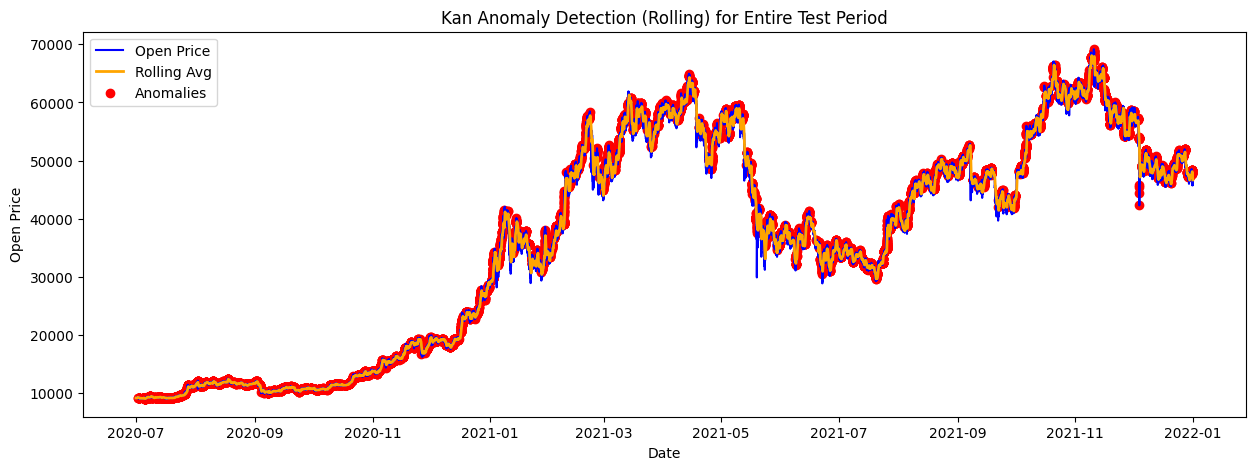

Trade executed: buy at 2020-07-02T06:08:00.000000000 (Entry Price: 9192.26), exited at 2020-07-02T07:06:00.000000000 (Exit Price: 9215.07), Volume: 0.2000, P&L: 0.0005
Trade executed: buy at 2020-07-02T15:01:00.000000000 (Entry Price: 9184.24), exited at 2020-07-02T21:38:00.000000000 (Exit Price: 9097.37), Volume: 0.2001, P&L: -0.0019
Trade executed: buy at 2020-07-02T15:04:00.000000000 (Entry Price: 9090.27), exited at 2020-07-02T21:38:00.000000000 (Exit Price: 9097.37), Volume: 0.2001, P&L: 0.0002
Trade executed: buy at 2020-07-02T15:05:00.000000000 (Entry Price: 9083.01), exited at 2020-07-02T21:38:00.000000000 (Exit Price: 9097.37), Volume: 0.2001, P&L: 0.0003
Trade executed: buy at 2020-07-02T15:06:00.000000000 (Entry Price: 9084.51), exited at 2020-07-02T21:38:00.000000000 (Exit Price: 9097.37), Volume: 0.2001, P&L: 0.0003
Trade executed: sell at 2020-07-04T17:35:00.000000000 (Entry Price: 9161.66), exited at 2020-07-04T19:02:00.000000000 (Exit Price: 9130.65), Volume: 0.1999, P&

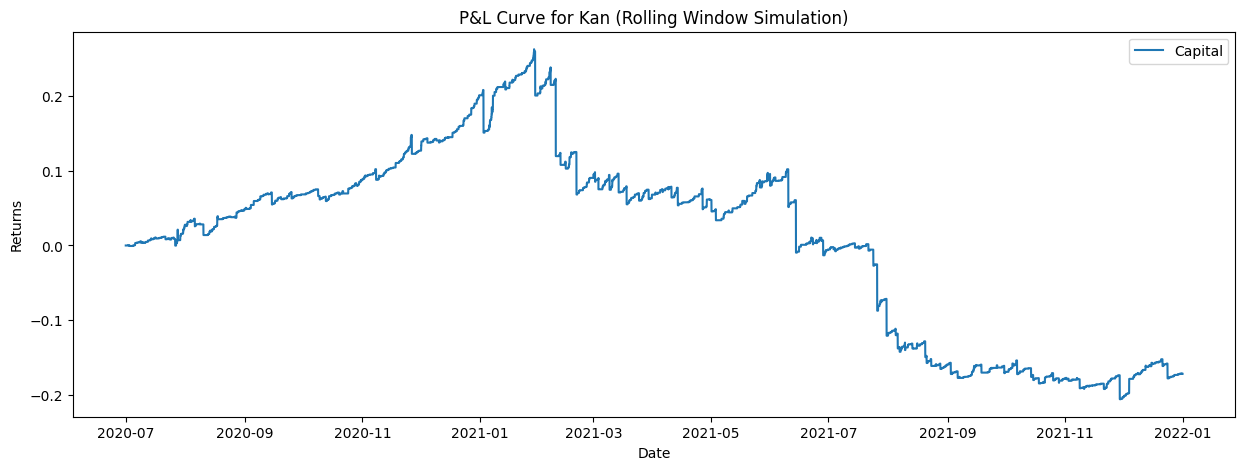

Final Capital for kan: 0.8285


In [38]:
for model_name in model_names:
    print(f"\n=== Final Outputs for Model: {model_name} ===")

    combined_scores[model_name] = np.array(combined_scores[model_name])
    scores = np.array(combined_scores[model_name])

    rolling_percentiles = np.zeros_like(scores, dtype=float) 
    rolling_anomalies   = np.zeros_like(scores, dtype=bool)  
    # rolling_stds = np.zeros_like(scores, dtype=float) 

    for i in range(window_size_minutes, len(scores)):
        start_idx = i - window_size_minutes
        end_idx = i  
        window_slice = scores[start_idx:end_idx]  

        current_score = scores[i]

        
        rank = percentileofscore(window_slice, current_score, kind='rank')
        # rolling_percentiles[i] = rank  

        if rank >= percentile:
            rolling_anomalies[i] = True
            
        # deviation = deviation_from_mean(window_slice[-99:], current_score)
        # rolling_stds[i] = deviation  
            
    anomaly_dates = np.array(combined_test_dates)[rolling_anomalies]
    print(f"Found {rolling_anomalies.sum()} anomalies using rolling percentile = {percentile}")

    plt.figure(figsize=(15, 5))
    unscaled_prices = np.array(original_prices_buffer)
    plt.plot(combined_test_dates, unscaled_prices, label='Open Price', color='blue')

    rolling_avg_values = original_data_sorted['rolling_avg'].reindex(combined_test_dates).values
    plt.plot(combined_test_dates, rolling_avg_values, label='Rolling Avg', color='orange', linewidth=2)

    anomaly_prices = unscaled_prices[rolling_anomalies]
    plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
    plt.title(f'{model_name.capitalize()} Anomaly Detection (Rolling) for Entire Test Period')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()

    # analysis_results = analyze_anomalies(anomaly_dates, original_data_sorted, window_minutes=window_minutes)
    # compute_statistics(analysis_results, model_name)

    ma_window = window_minutes
    original_data_sorted['MA'] = original_data_sorted['close'].rolling(window=ma_window, min_periods=1).mean()
    
    combined_test_data = original_data_sorted.loc[combined_test_dates, 'close']
    combined_ma_data = original_data_sorted.loc[combined_test_dates, 'MA']

    if mode == 'percentile':
        capital_history = simulate_trading_percentile(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'close'],
            ma_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            scores=scores,
            rolling_percentiles=rolling_percentiles,  
            rolling_anomalies=rolling_anomalies,      
            percentile=percentile,
            max_entries=max_entries,
        )
    elif mode == 'std':
        capital_history, closed_trades = simulate_trading_std(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'close'],
            scaled_prices=scaled_prices,
            predicted_prices=combined_predictions[model_name],
            ma_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            rsi_data=original_data_sorted.loc[combined_test_dates, 'rsi'],
            scores=scores,
            rolling_anomalies=rolling_anomalies,      
            num_std=num_std,
            max_entries=max_entries,
            exit_val = exit_val,
            distr_len=99,  
            num_std_exit = 1,
        )

    plt.figure(figsize=(15, 5))
    plt.plot(capital_history.index, capital_history.values - 1, label='Capital')
    plt.title(f'P&L Curve for {model_name.capitalize()} (Rolling Window Simulation)')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

    final_capital = capital_history.iloc[-1]
    print(f"Final Capital for {model_name}: {final_capital:.4f}")

In [14]:
def calc_pl(data_dict, params):
    results_dict = {}

    num_std = params.get('num_std', 1)
    num_std_exit = params.get('num_std_exit', 1)
    percentile = params.get('percentile', 99.5)
    exit_val = params.get('exit_val', 'rsi')  
    max_entries = params.get('max_entries', 5)
    plot_pl = params.get('plot_pl', False)
    distr_len = params.get('distr_len', 99)
    window_minutes = params.get('window_minutes', 500)
    window_size_minutes = params.get('window_size_minutes', 500)
    rsi_entry = params.get('rsi_entry', [40, 60])
    rsi_exit = params.get('rsi_exit', [60, 40])
    max_entries = params.get('max_entries', 5)
    print_trades = params.get('print_trades', False)
    comission_rate = params.get('comission_rate', 0.0002)

    for ticker, df in data_dict.items():
        print(f"\n=== Processing Ticker: {ticker} ===")
        price_data = df['close']
        scaled_prices = df['scaled_price']
        predicted_prices = df['predicted_price']
        rsi_data = calculate_rsi(df, window=window_minutes)
        ma_data = df['close'].rolling(window=window_minutes, min_periods=1).mean()
        scores = df['scores'].values  # array

        rolling_anomalies = np.zeros_like(scores, dtype=bool)

        for i in range(window_size_minutes, len(scores)):
            start_idx = i - window_minutes
            end_idx = i
            window_slice = scores[start_idx:end_idx]
            current_score = scores[i]

            rank = percentileofscore(window_slice, current_score, kind='rank')
            if rank >= percentile:
                rolling_anomalies[i] = True
        print(rolling_anomalies.sum())
        profits, closed_trades = simulate_trading_std(
            model_name='kan',  
            price_data=price_data,
            scaled_prices=scaled_prices,
            predicted_prices=predicted_prices,
            ma_data=ma_data,
            rsi_data=rsi_data,
            scores=scores,
            rolling_anomalies=rolling_anomalies,
            num_std=num_std,
            max_entries=max_entries,
            exit_val=exit_val,
            distr_len=distr_len,
            num_std_exit=num_std_exit,
            rsi_entry=rsi_entry,
            rsi_exit=rsi_exit,
            print_trades=print_trades,
            comission_rate=comission_rate,
        )


        if plot_pl:
            plt.figure(figsize=(12, 5))
            plt.plot(profits.index, profits.cumsum(), label='Profits history')
            plt.title(f'P&L Curve for {ticker} (exit_val={exit_val})')
            plt.xlabel('Date')
            plt.ylabel('Returns')
            plt.legend()
            plt.show()

        
        daily_rets = profits.resample('D').sum()

        results_dict[ticker] = daily_rets

    combined_returns = pd.concat(results_dict.values(), axis=1).sum(axis=1)
    return combined_returns, closed_trades, rolling_anomalies #######

In [15]:
dates = pd.to_datetime(combined_test_dates)  
df = pd.DataFrame(index=dates)
df.index.name = "datetime"

df["close"] = original_prices_buffer  
df["scaled_price"] = scaled_prices
df["scores"] = combined_scores['kan']

df["predicted_price"] = combined_predictions['kan']

data_dict = {"BTCUSDT": df}

best_params = {
    'num_std': 2, 
    'num_std_exit': 1,
    'percentile': 99.5,
    'exit_val': 'rsi',
    'max_entries': 5,
    'window_minutes': 500,
    'window_size_minutes': 5000,
    'rsi_entry': (40, 60),
    'rsi_exit': (50, 50),
    'plot_pl': True,
    'distr_len': 99,
    'print_trades': True,
    'comission_rate': 0.0002,
}

In [16]:
results, closed_trades, rolling_anomalies = calc_pl(data_dict, best_params)


=== Processing Ticker: BTCUSDT ===
13337
Trade executed: sell at 2020-07-21T07:44:00.000000000 (Entry Price: 9322.31), exited at 2020-07-21T09:54:00.000000000 (Exit Price: 9315.54), Volume: 0.2000, P&L: 0.0001
Trade executed: sell at 2020-07-26T10:05:00.000000000 (Entry Price: 10218.60), exited at 2020-07-26T10:11:00.000000000 (Exit Price: 10062.67), Volume: 0.2000, P&L: 0.0030
Trade executed: sell at 2020-07-26T10:03:00.000000000 (Entry Price: 10019.74), exited at 2020-07-26T11:38:00.000000000 (Exit Price: 9967.01), Volume: 0.2000, P&L: 0.0010


/tmp/ipykernel_20555/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_20555/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]


Trade executed: sell at 2020-10-10T02:06:00.000000000 (Entry Price: 11412.20), exited at 2020-10-10T02:07:00.000000000 (Exit Price: 11349.16), Volume: 0.2008, P&L: 0.0011
Trade executed: sell at 2020-10-10T02:07:00.000000000 (Entry Price: 11349.16), exited at 2020-10-10T09:46:00.000000000 (Exit Price: 11307.96), Volume: 0.2010, P&L: 0.0007
Trade executed: sell at 2021-02-08T12:57:00.000000000 (Entry Price: 43055.42), exited at 2021-02-08T17:09:00.000000000 (Exit Price: 42677.58), Volume: 0.2012, P&L: 0.0017
Trade executed: sell at 2021-04-10T04:21:00.000000000 (Entry Price: 61571.56), exited at 2021-04-10T04:27:00.000000000 (Exit Price: 60897.55), Volume: 0.2015, P&L: 0.0022
Trade executed: sell at 2021-07-26T01:01:00.000000000 (Entry Price: 39814.35), exited at 2021-07-26T01:03:00.000000000 (Exit Price: 38900.74), Volume: 0.2020, P&L: 0.0046
Trade executed: sell at 2021-07-26T16:27:00.000000000 (Entry Price: 39211.56), exited at 2021-07-26T17:01:00.000000000 (Exit Price: 38874.88), Vo

In [73]:
params = {
    "num_std": [1, 2],
    "num_std_exit": [1, 2, 3],
    "percentile": [99, 99.5],
    "exit_val": ["rsi", "ma"],   # or "ma"
    "max_entries": [5, 10],
    "plot_pl": False,
    "distr_len": 99,
    "window_minutes": [50, 500],
    "window_size_minutes": [1000, 5000],
    "rsi_entry": [(30, 70), (40, 60)],
    "rsi_exit": [(70, 30), (60, 40), (50, 50)],
    "print_trades": False,
    "comission_rate": 0.0002
}

In [74]:
save_path = 'results/'
file_prefix = f"anomaly"

optimizer = ParameterOptimizer(
        calc_pl, save_path=save_path, save_file_prefix=file_prefix, n_jobs=1
    )

optimizer.split_data(data_dict, "2021-06-01")
optimizer.optimize(
    data_dict=data_dict, params=params, n_runs=64, best_trials_pct=0.1, n_splits=3, n_test_splits=1
)


2025-02-10 13:09:18,978 - INFO - Splitting data into train and test sets with cutoff: 2021-06-01
2025-02-10 13:09:19,007 - WARNING - Data integrity check errors: ['DataFrame for BTCUSDT has 15 gaps in its index. Largest gap is 0 days 01:56:00. Expected interval is 0 days 00:01:00.']
Processing tickers:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/backtest_optimizer/main.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].astype("float32", copy=False)
/opt/conda/lib/python3.11/site-packages/backtest_optimizer/main.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:09:43,551] Trial 0 finished with value: -1.1410504389478529 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 0 with value: -1.1410504389478529.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:10:08,204] Trial 1 finished with value: -1.612126631998278 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 0 with value: -1.1410504389478529.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:10:31,905] Trial 2 finished with value: -0.48231649191890763 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 2 with value: -0.48231649191890763.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
32565


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:10:54,600] Trial 3 finished with value: 0.6512833752077944 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 3 with value: 0.6512833752077944.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:11:18,850 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:11:18,851 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:11:18,852 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:11:18,852 - WARNING - Trial 4 returned NaN Sharpe ratio.
[I 2025-02-10 13:11:18,854] Trial 4 finished with value: -1000000.0 and para


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:11:43,219] Trial 5 finished with value: 1.8066159013316516 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 5 with value: 1.8066159013316516.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32565


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:12:05,812] Trial 6 finished with value: 0.5268354794351812 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 5 with value: 1.8066159013316516.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:12:29,722] Trial 7 finished with value: -1.6282043940322066 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 5 with value: 1.8066159013316516.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:12:52,107] Trial 8 finished with value: 0.3182044574487074 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 5 with value: 1.8066159013316516.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:13:14,876] Trial 9 finished with value: -1.263590478695299 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 5 with value: 1.8066159013316516.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:13:38,384] Trial 10 finished with value: 1.8199634629723145 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:14:02,254] Trial 12 finished with value: 1.8066159013316516 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:14:25,957] Trial 13 finished with value: 1.1702235934857148 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:14:49,547 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:14:49,548 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:14:49,549 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:14:49,550 - WARNING - Trial 14 returned NaN Sharpe ratio.
[I 2025-02-10 13:14:49,551] Trial 14 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:15:12,999] Trial 15 finished with value: -0.1920894740586291 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:15:37,176] Trial 16 finished with value: 1.8192061713105852 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:16:00,914] Trial 17 finished with value: 1.6711394419470693 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:16:24,302] Trial 18 finished with value: 1.0093186076189937 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:16:47,769] Trial 19 finished with value: -1.3431767303647446 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:17:11,312] Trial 20 finished with value: 1.8188605468006684 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:17:34,782 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:17:34,783 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:17:34,783 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:17:34,784 - WARNING - Trial 22 returned NaN Sharpe ratio.
[I 2025-02-10 13:17:34,785] Trial 22 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:17:57,404] Trial 23 finished with value: -1.036921258477368 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:18:21,055] Trial 24 finished with value: -0.9769674895485531 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 10 with value: 1.8199634629723145.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:18:45,873] Trial 25 finished with value: 1.8803932421277838 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 25 with value: 1.8803932421277838.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:19:10,406] Trial 26 finished with value: 1.8077841224955045 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 25 with value: 1.8803932421277838.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:19:34,716] Trial 28 finished with value: 1.710036814773049 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 25 with value: 1.8803932421277838.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:19:59,542] Trial 29 finished with value: 1.4662610215185043 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 25 with value: 1.8803932421277838.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:20:24,096] Trial 30 finished with value: -1.6348763758790694 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 25 with value: 1.8803932421277838.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:20:48,095] Trial 31 finished with value: 1.9008202997969508 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:21:11,168] Trial 32 finished with value: -1.8229613490757723 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:21:35,200] Trial 34 finished with value: -1.5715307522023898 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32565


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:21:58,605] Trial 35 finished with value: -2.119170294823262 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:22:22,501 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:22:22,502 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:22:22,503 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:22:22,504 - WARNING - Trial 36 returned NaN Sharpe ratio.
[I 2025-02-10 13:22:22,505] Trial 36 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:22:45,072] Trial 37 finished with value: -0.7777423547594694 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:23:10,067 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:23:10,068 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:23:10,068 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:23:10,070 - WARNING - Trial 38 returned NaN Sharpe ratio.
[I 2025-02-10 13:23:10,071] Trial 38 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:23:34,090] Trial 39 finished with value: 0.7209493272344185 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:23:58,998] Trial 41 finished with value: 1.1971063735391037 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:24:23,217] Trial 42 finished with value: -1.2839349465469194 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:24:47,722] Trial 43 finished with value: 1.822174648841795 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:25:12,604] Trial 45 finished with value: -1.1609609175032218 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:25:37,340 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:25:37,341 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:25:37,342 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:25:37,343 - WARNING - Trial 46 returned NaN Sharpe ratio.
[I 2025-02-10 13:25:37,344] Trial 46 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:26:01,644] Trial 47 finished with value: 1.7574245755143076 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:26:26,309] Trial 48 finished with value: 1.6600870608374434 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:26:51,693] Trial 49 finished with value: 1.633299212165381 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:27:16,004] Trial 50 finished with value: 1.1495302001526138 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:27:40,099] Trial 51 finished with value: -1.517115718551965 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:28:04,152] Trial 52 finished with value: -1.351781742798497 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:28:28,346] Trial 53 finished with value: 1.4980573882870696 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:28:52,535] Trial 54 finished with value: 1.633456508556893 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:29:17,103 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:29:17,103 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:29:17,104 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:29:17,105 - WARNING - Trial 55 returned NaN Sharpe ratio.
[I 2025-02-10 13:29:17,106] Trial 55 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
14253


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:29:41,858] Trial 56 finished with value: 1.7970219572515695 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:30:06,263] Trial 57 finished with value: -1.350733138064593 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
8965


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:30:31,038 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:30:31,039 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:30:31,039 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:30:31,040 - WARNING - Trial 58 returned NaN Sharpe ratio.
[I 2025-02-10 13:30:31,042] Trial 58 finished with value: -1000000.0 and pa


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:30:55,327] Trial 59 finished with value: -1.4968422373653716 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
14110


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:31:19,212] Trial 60 finished with value: 1.6484051270951514 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
9059


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:31:43,576] Trial 62 finished with value: 1.6711394419470693 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 31 with value: 1.9008202997969508.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32305


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:32:06,028] Trial 63 finished with value: -1.0766212767540742 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 31 with value: 1.9008202997969508.
2025-02-10 13:32:06,036 - INFO - Top 0.1 param combina


=== Processing Ticker: BTCUSDT ===
4245


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:32:17,973 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': 0, 'sharpe': np.float64(1.8970761516213217)}



=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:32:29,986 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(1.8970761516213217)}



=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:32:41,711 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(1.3922550549405428)}



=== Processing Ticker: BTCUSDT ===
6996


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:32:54,039 - INFO - Val performance: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(1.3992782625768172)}



=== Processing Ticker: BTCUSDT ===
4245


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:33:05,917 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(1.3498116303471288)}
2025-


=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7615


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:33:30,165] Trial 0 finished with value: 1.8264560976020054 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 0 with value: 1.8264560976020054.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
6996


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7517


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:33:54,469] Trial 1 finished with value: -0.18764003818941566 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 0 with value: 1.8264560976020054.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:34:18,785] Trial 2 finished with value: 1.875311807599544 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 2 with value: 1.875311807599544.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7615


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:34:43,491 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:34:43,492 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:34:43,493 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:34:43,493 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:34:43,494 - ERRO


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:35:06,694] Trial 4 finished with value: 2.052417339292593 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 4 with value: 2.052417339292593.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.p


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:35:29,874] Trial 5 finished with value: 1.2632369337913942 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 4 with value: 2.052417339292593.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7615


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:35:54,645] Trial 6 finished with value: -0.4696434513251634 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 4 with value: 2.052417339292593.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7615


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:36:19,045 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:36:19,046 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:36:19,047 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:36:19,048 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:36:19,049 - ERRO


=== Processing Ticker: BTCUSDT ===
4308


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
4843


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:36:43,574] Trial 8 finished with value: 2.08602161619122 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 8 with value: 2.08602161619122.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.


=== Processing Ticker: BTCUSDT ===
7092


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7615


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:37:07,530] Trial 9 finished with value: -0.4696434513251634 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 8 with value: 2.08602161619122.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
4245


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
4782


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:37:31,999 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:37:32,000 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:37:32,001 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:37:32,002 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:37:32,003 - ERRO


=== Processing Ticker: BTCUSDT ===
6996


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7517


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:37:55,630] Trial 13 finished with value: 1.9229430817881301 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 8 with value: 2.08602161619122.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:38:18,739] Trial 14 finished with value: 1.4839059231256049 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 8 with value: 2.08602161619122.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:38:42,422] Trial 15 finished with value: 0.6302897485124617 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 8 with value: 2.08602161619122.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.


=== Processing Ticker: BTCUSDT ===
4308


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
4843


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:39:06,811 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:39:06,812 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:39:06,813 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:39:06,814 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:39:06,814 - ERRO


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:39:31,081] Trial 17 finished with value: 3.6725443685944894 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 17 with value: 3.6725443685944894.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:39:54,404] Trial 18 finished with value: 1.4353521003896517 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 17 with value: 3.6725443685944894.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:40:18,459] Trial 19 finished with value: 3.8148654255945083 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 19 with value: 3.8148654255945083.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:40:41,896] Trial 21 finished with value: 0.8698294113373981 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 19 with value: 3.8148654255945083.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:41:04,401] Trial 22 finished with value: 3.6725443685944894 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 19 with value: 3.8148654255945083.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:41:27,621] Trial 24 finished with value: 4.761768628857002 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:41:50,810] Trial 26 finished with value: -0.09995514726173621 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:42:13,272] Trial 27 finished with value: 4.293925374126726 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
6996


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7517


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:42:37,029 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:42:37,030 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:42:37,031 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:42:37,032 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:42:37,032 - ERRO


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:43:00,228] Trial 30 finished with value: 0.04519260670796732 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:43:23,786] Trial 31 finished with value: 4.1355664457823895 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:43:47,250] Trial 32 finished with value: 1.2419632116809933 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 24 with value: 4.761768628857002.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
6996


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
7517


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:44:11,624 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:44:11,624 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:44:11,625 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:44:11,626 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:44:11,626 - ERRO


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:44:34,672] Trial 35 finished with value: 4.8068105415000595 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 35 with value: 4.8068105415000595.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:44:57,795] Trial 36 finished with value: 1.25378904234247 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 35 with value: 4.8068105415000595.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:45:21,521] Trial 38 finished with value: 4.77028817971581 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 35 with value: 4.8068105415000595.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:45:44,567] Trial 39 finished with value: 2.3399269119716717 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 35 with value: 4.8068105415000595.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:46:07,771] Trial 40 finished with value: 4.817409627684568 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:46:30,721] Trial 41 finished with value: 1.5497770914191804 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:46:53,383] Trial 43 finished with value: 4.651500781195041 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:47:16,527] Trial 45 finished with value: 0.21145082714015895 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
4245


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
4782


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:47:40,708 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:47:40,708 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:47:40,709 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:47:40,710 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:47:40,711 - ERRO


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:48:03,906] Trial 48 finished with value: 1.4300913347390372 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:48:27,064] Trial 49 finished with value: 1.3034849991826523 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:48:51,580] Trial 50 finished with value: 3.9209558737397114 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:49:14,089] Trial 51 finished with value: 1.483933893297582 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:49:40,110] Trial 52 finished with value: 4.243619586497385 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:50:08,412] Trial 53 finished with value: 1.1676189794633185 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:50:36,968] Trial 54 finished with value: 2.1118418104484062 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:51:03,422] Trial 55 finished with value: 1.019569640029613 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:51:25,779] Trial 56 finished with value: 1.4510442003769934 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:51:50,179] Trial 57 finished with value: 0.13084607997059294 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:52:13,367] Trial 58 finished with value: 0.9841156758387134 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
16606


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:52:36,538] Trial 59 finished with value: 1.5590922827112101 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
4308


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
4843


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:53:07,013 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:53:07,014 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:53:07,015 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:53:07,016 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:53:07,017 - ERRO


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:53:30,563] Trial 61 finished with value: 0.22346683422382718 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 40 with value: 4.817409627684568.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
16856


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]



=== Processing Ticker: BTCUSDT ===
16995


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:53:59,234] Trial 63 finished with value: 4.380050726750905 and parameters: {'num_std': 1, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 40 with value: 4.817409627684568.
2025-02-10 13:53:59,243 - INFO - Top 0.1 param combinatio


=== Processing Ticker: BTCUSDT ===
15502


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:54:13,637 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': 1, 'sharpe': np.float64(0.18220431300461531)}



=== Processing Ticker: BTCUSDT ===
15502


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:54:27,988 - INFO - Val performance: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(0.8296174198032373)}



=== Processing Ticker: BTCUSDT ===
15502


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:54:39,690 - INFO - Val performance: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(0.39652372607351744)}



=== Processing Ticker: BTCUSDT ===
15242


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:54:51,195 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(1.0883215622138416)}



=== Processing Ticker: BTCUSDT ===
15242


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:55:02,615 - INFO - Val performance: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(0.8974240570301867)}
2025-


=== Processing Ticker: BTCUSDT ===
13764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:55:27,881 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:55:27,882 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:55:27,882 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:55:27,883 - WARNING - Trial 0 returned NaN Sharpe ratio.
[I 2025-02-10 13:55:27,884] Trial 0 finished with value: -1000000.0 and para


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:55:52,501] Trial 1 finished with value: -0.3211757880107281 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:56:17,545] Trial 2 finished with value: -0.997216615580102 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
13764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:56:42,085] Trial 3 finished with value: -0.40092336821458546 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
8552


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:57:06,632] Trial 4 finished with value: -0.788852840520918 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
8552


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:57:34,498 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:57:34,499 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:57:34,499 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:57:34,501 - WARNING - Trial 5 returned NaN Sharpe ratio.
[I 2025-02-10 13:57:34,502] Trial 5 finished with value: -1000000.0 and para


=== Processing Ticker: BTCUSDT ===
8552


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:58:00,563] Trial 6 finished with value: -0.7893183680664445 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
8552


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:58:25,098] Trial 7 finished with value: -0.5490325885299104 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 1 with value: -0.3211757880107281.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:58:48,195] Trial 8 finished with value: 3.010916727157012 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 8 with value: 3.010916727157012.
/opt/conda/lib/python3.11/site-packages/optuna/distributions.py


=== Processing Ticker: BTCUSDT ===
8489


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 13:59:12,387 - WARNING - Standard deviation of returns is zero. Sharpe ratio is set to NaN.
2025-02-10 13:59:12,388 - WARNING - Annual Sharpe ratio calculated as NaN.
2025-02-10 13:59:12,388 - ERROR - All Sharpe ratios are NaN.
2025-02-10 13:59:12,389 - WARNING - Trial 9 returned NaN Sharpe ratio.
[I 2025-02-10 13:59:12,390] Trial 9 finished with value: -1000000.0 and para


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:59:35,070] Trial 10 finished with value: 3.0902348180570285 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 10 with value: 3.0902348180570285.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 13:59:58,604] Trial 12 finished with value: 3.120817993364729 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 12 with value: 3.120817993364729.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:00:22,036] Trial 14 finished with value: 1.0399641355404952 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 12 with value: 3.120817993364729.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:00:44,992] Trial 15 finished with value: 3.2281761262219653 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:01:08,054] Trial 17 finished with value: 3.0320730941361713 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:01:31,343] Trial 18 finished with value: 3.121445708614828 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:01:54,048] Trial 20 finished with value: 3.121445708614828 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:02:16,903] Trial 22 finished with value: 2.9893900121398764 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:02:39,616] Trial 23 finished with value: 3.2281761262219653 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:03:02,790] Trial 25 finished with value: 3.03603385561333 and parameters: {'num_std': 1, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:03:25,610] Trial 26 finished with value: 3.0388398816224353 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:03:48,134] Trial 27 finished with value: -0.5279416494507356 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:04:11,245] Trial 28 finished with value: 2.9893900121398764 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
8489


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:04:35,183] Trial 29 finished with value: -0.6143461316303404 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
8552


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:04:59,860] Trial 30 finished with value: -0.6200371359448607 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distrib


=== Processing Ticker: BTCUSDT ===
8489


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:05:24,404] Trial 31 finished with value: -0.626575461577397 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:05:47,725] Trial 32 finished with value: 3.1391956004176857 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:06:10,745] Trial 34 finished with value: 2.6585624169029454 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:06:34,823] Trial 35 finished with value: 1.3072267108428104 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:06:58,197] Trial 36 finished with value: 3.206210044400573 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:07:21,230] Trial 37 finished with value: 3.206210044400573 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:07:46,032] Trial 40 finished with value: -0.5947314502835722 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:08:09,217] Trial 41 finished with value: 3.2281761262219653 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:08:34,167] Trial 43 finished with value: -0.3211757880107281 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:08:57,123] Trial 44 finished with value: 3.0902348180570285 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:09:20,313] Trial 45 finished with value: 3.2281761262219653 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:09:43,164] Trial 46 finished with value: 3.1391956004176857 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:10:07,198] Trial 47 finished with value: 0.010806241433007294 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distri


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:10:30,277] Trial 48 finished with value: 3.206210044400573 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributions


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:10:57,245] Trial 49 finished with value: 3.2281761262219653 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:11:23,684] Trial 52 finished with value: 0.9633627904548829 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'rsi', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribut


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:11:46,983] Trial 53 finished with value: 3.206210044400573 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributio


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:12:10,502] Trial 54 finished with value: 3.121445708614828 and parameters: {'num_std': 1, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribution


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:12:33,243] Trial 55 finished with value: 3.120817993364729 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:12:57,761] Trial 56 finished with value: 3.0902348180570285 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:13:21,292] Trial 57 finished with value: 2.747841407640908 and parameters: {'num_std': 2, 'num_std_exit': 1, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
13764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:13:46,574] Trial 58 finished with value: -0.44182587715269434 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32415


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:14:11,297] Trial 59 finished with value: 2.8123470375534496 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 1000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:14:35,929] Trial 60 finished with value: 0.9920087537104171 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'rsi', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:15:00,561] Trial 61 finished with value: -0.5147216348236975 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 5, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distributi


=== Processing Ticker: BTCUSDT ===
13668


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:15:25,362] Trial 62 finished with value: -0.43728635809053895 and parameters: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 500, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
/opt/conda/lib/python3.11/site-packages/optuna/distribu


=== Processing Ticker: BTCUSDT ===
32165


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
[I 2025-02-10 14:15:49,005] Trial 63 finished with value: 3.120817993364729 and parameters: {'num_std': 2, 'num_std_exit': 2, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30)}. Best is trial 15 with value: 3.2281761262219653.
2025-02-10 14:15:49,021 - INFO - Top 0.1 param combinations


=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 14:16:00,915 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': 2, 'sharpe': np.float64(-1.6684326001098297)}



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 14:16:12,589 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (70, 30), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(-1.6684326001098297)}



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 14:16:23,866 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99.5, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (40, 60), 'rsi_exit': (70, 30), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(-1.6684326001098297)}



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 14:16:35,429 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (50, 50), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(-1.6684326001098297)}



=== Processing Ticker: BTCUSDT ===
16764


/tmp/ipykernel_996/2328780399.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scaled_price = scaled_prices[i]
/tmp/ipykernel_996/2328780399.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price = predicted_prices[i]
2025-02-10 14:16:46,503 - INFO - Val performance: {'num_std': 2, 'num_std_exit': 3, 'percentile': 99, 'exit_val': 'ma', 'max_entries': 10, 'window_minutes': 50, 'window_size_minutes': 5000, 'rsi_entry': (30, 70), 'rsi_exit': (60, 40), 'plot_pl': False, 'distr_len': 99, 'print_trades': False, 'comission_rate': 0.0002, 'fold_num': nan, 'sharpe': np.float64(-1.6684326001098297)}
2025-02

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

def plot_trades(
    closed_trades,
    price_data,
    rsi_data=None,
    ma_data=None,
    anomalies=None,
    exit_val="rsi",
    num_plots=None,
):
    """
    Plot trades on top of price data. If exit_val='rsi', RSI is plotted on a separate y-axis.
    If exit_val='ma', we plot MA on the same y-axis as price.
    Also mark anomalies, entry and exit points for each trade.

    Args:
        closed_trades (list of dict):
            Each dict has e.g.:
            {
                "type": ..., "entry_time": ..., "entry_price": ...,
                "exit_time": ..., "exit_price": ..., "profit": ...
            }
        price_data (pd.Series):
            Price time series with a datetime index.
        rsi_data (pd.Series or None):
            RSI time series with the same index, if exit_val="rsi".
        ma_data (pd.Series or None):
            MA time series with the same index, if exit_val="ma".
        anomalies (np.ndarray of bool or None):
            Boolean array indicating anomalies; same length as price_data.
        exit_val (str):
            "rsi" or "ma" – determines which exit logic was used and how to plot it.
        num_plots (int or None):
            If provided, only plot that many random exit-time groups.
    """

    if anomalies is None:
        anomalies = np.zeros(len(price_data), dtype=bool)
    price_index = price_data.index

    # Group trades by exit_time
    trades_by_exit_time = defaultdict(list)
    for t in closed_trades:
        trades_by_exit_time[t['exit_time']].append(t)

    # We only want unique exit times
    unique_exit_times = list(trades_by_exit_time.keys())
    unique_exit_times.sort()

    # If num_plots is specified, pick a random subset of exit times
    if num_plots is not None and num_plots < len(unique_exit_times):
        unique_exit_times = random.sample(unique_exit_times, num_plots)
        unique_exit_times.sort()

    for exit_time in unique_exit_times:
        trades_group = trades_by_exit_time[exit_time]

        # Determine the earliest entry_time among these trades
        entry_time_min = min(tr['entry_time'] for tr in trades_group)
        # We'll plot from entry_time_min to exit_time
        if entry_time_min > exit_time:
            continue  # edge case if data is out of order

        entry_time_min_adj = entry_time_min - pd.Timedelta(minutes=30)
        exit_time_adj = exit_time + pd.Timedelta(minutes=30)

        mask = (price_index >= entry_time_min_adj) & (price_index <= exit_time_adj)
        sub_price = price_data[mask]


        # Sub anomalies
        if len(anomalies) == len(price_index):
            sub_anomalies = anomalies[mask]
        else:
            sub_anomalies = np.zeros(len(sub_price), dtype=bool)

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))

        # === Primary axis (Price) ===
        ax.plot(sub_price.index, sub_price.values, label='Price', color='blue')
        ax.set_ylabel("Price")

        # We'll store line/label info for legend
        lines_1, labels_1 = ax.get_legend_handles_labels()

        # === If exit_val == "ma", plot MA on the same axis ===
        if exit_val == "ma" and ma_data is not None:
            sub_ma = ma_data[mask]
            line2 = ax.plot(sub_ma.index, sub_ma.values, label='MA', color='orange')
            lines_2, labels_2 = ax.get_legend_handles_labels()
            # new lines/labels might now include MA
            lines_1 += line2
            labels_1 += ['MA']

        # === Mark anomalies (on price axis) ===
        anomaly_idx = sub_price.index[sub_anomalies]
        anomaly_prices = sub_price.loc[anomaly_idx]
        scatter_anoms = ax.scatter(anomaly_idx, anomaly_prices, color='red', marker='x', label='Anomaly')

        # The scatter object won't appear in lines/labels automatically
        lines_1.append(scatter_anoms)
        labels_1.append("Anomaly")

        # === If exit_val == "rsi", create a twin y-axis for RSI ===
        if exit_val == "rsi" and rsi_data is not None:
            sub_rsi = rsi_data[mask]
            ax2 = ax.twinx()
            ax2.set_ylabel("RSI")
            line_rsi = ax2.plot(sub_rsi.index, sub_rsi.values, label='RSI', color='orange')
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            lines_rsi, labels_rsi = line_rsi, ['RSI']

            # We'll handle combined legend from both axes:
            lines_combined = lines_1 + lines_rsi
            labels_combined = labels_1 + labels_rsi
        else:
            # no second axis
            ax2 = None
            lines_combined = lines_1
            labels_combined = labels_1

        # === Plot trade entries/exits ===
        for trade in trades_group:
            entry_time = trade['entry_time']
            exit_time_ = trade['exit_time']
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']

            trade_type = trade['type']
            marker_entry = '^' if trade_type == 'buy' else 'v'
            color_entry = 'green' if trade_type == 'buy' else 'orange'

            # Plot entry on primary axis
            if entry_time in sub_price.index:
                sc_entry = ax.scatter(entry_time, entry_price,
                                      color=color_entry, marker=marker_entry, s=100,
                                      label=f"{trade_type.capitalize()} Entry @ {entry_price:.2f}")

                # We must check if this label is new or duplicated
                # For simplicity, let's just add them to lines/labels:
                lines_combined.append(sc_entry)
                labels_combined.append(f"{trade_type.capitalize()} Entry")

            # Plot exit on primary axis
            if exit_time_ in sub_price.index:
                sc_exit = ax.scatter(exit_time_, exit_price,
                                     color='red', marker='o', s=100,
                                     label=f"Exit @ {exit_price:.2f}")
                lines_combined.append(sc_exit)
                labels_combined.append("Exit")

        ax.set_title(f"Trades from {entry_time_min} to {exit_time} (exit_val='{exit_val}')")
        ax.set_xlabel("Time")

        # === Build a combined legend if we have a second axis (RSI) ===
        # or we can just do one axis's legend if exit_val!='rsi'
        ax.legend(lines_combined, labels_combined, loc='best')
        plt.show()


In [18]:
plot_trades(
    closed_trades=closed_trades,
    price_data=original_data_sorted.loc[combined_test_dates, 'close'],
    rsi_data=original_data_sorted.loc[combined_test_dates, 'rsi'],
    ma_data=None, #original_data_sorted.loc[combined_test_dates, 'MA'],
    anomalies=rolling_anomalies,
    exit_val="rsi",   # rsi or "ma"
    num_plots=5       # optional
)

In [96]:
def plot_true_vs_predicted(unscaled_prices, combined_test_dates, benchmark_extreme_regions, anomaly_dates, num_windows=3, window_duration="1D"):
    if not isinstance(window_duration, pd.Timedelta):
        window_duration = pd.Timedelta(window_duration)
    
    df = pd.DataFrame({"datetime": combined_test_dates, "price": unscaled_prices})
    df.set_index("datetime", inplace=True)
    
    full_start = df.index[0]
    full_end = df.index[-1]

    valid_start_indices = [i for i, t in enumerate(df.index) if t + window_duration <= full_end]

    if len(valid_start_indices) >= num_windows:
        selected_start_indices = random.sample(valid_start_indices, num_windows)
    else:
        selected_start_indices = valid_start_indices

    selected_start_indices.sort()
    selected_start_indices = [combined_test_dates.index(pd.Timestamp('2020-12-06 03:05:00'))]
    for start_idx in selected_start_indices:
        window_start = df.index[start_idx]
        window_end = window_start + window_duration
        window_df = df.loc[window_start:window_end]

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(window_df.index, window_df["price"], label="Price", color="black", linewidth=1)

        label_true = label_predicted = False

        # True anomalies (benchmark extreme regions)
        for start_idx, end_idx, _ in benchmark_extreme_regions:
            region_start, region_end = combined_test_dates[start_idx], combined_test_dates[end_idx]
            if region_end >= window_start and region_start <= window_end:
                plot_start = max(region_start, window_start)
                plot_end = min(region_end, window_end)
                if not label_true:
                    ax.axvspan(plot_start, plot_end, color="blue", alpha=0.3, label="True Anomaly (Benchmark)")
                    label_true = True
                else:
                    ax.axvspan(plot_start, plot_end, color="blue", alpha=0.3)

        # Predicted anomalies
        window_pred_anomalies = [t for t in anomaly_dates if window_start <= t <= window_end]
        for t in window_pred_anomalies:
            if not label_predicted:
                ax.axvline(t, color="red", linestyle="--", alpha=0.8, label="Predicted Anomaly")
                label_predicted = True
            else:
                ax.axvline(t, color="red", linestyle="--", alpha=0.8)

        ax.set_title(f"Comparison: {window_start} to {window_end}")
        ax.set_xlabel("Datetime")
        ax.set_ylabel("Price")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [101]:
benchmark_extreme_regions = mark_extreme_regions(
    list(unscaled_prices), 
    threshold_abs=0.0, 
    threshold_pct=0.03, 
    use_pct=False, 
    dynamic_threshold=True, 
    vol_window=55, 
    vol_multiplier=80.0, 
    confirmation_period=2, 
    region_tolerance_pct=0.01
)

benchmark_anomaly_dates = set()
for start_idx, end_idx, _ in benchmark_extreme_regions:
    benchmark_anomaly_dates.update(combined_test_dates[start_idx:end_idx + 1])

from sklearn.metrics import precision_score, recall_score, f1_score

# Convert to sets for comparison
model_anomalies = set(anomaly_dates)
true_anomalies = benchmark_anomaly_dates

# Define True Positives, False Positives, and False Negatives
tp = len(model_anomalies & true_anomalies)  # Intersection
fp = len(model_anomalies - true_anomalies)  # In model but not in benchmark
fn = len(true_anomalies - model_anomalies)  # In benchmark but not in model

# Precision, Recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
iou = len(model_anomalies & true_anomalies) / len(model_anomalies | true_anomalies) if len(model_anomalies | true_anomalies) > 0 else 0
print(f"IoU (Jaccard Index): {iou:.4f}")


Precision: 0.9878
Recall: 0.0146
F1 Score: 0.0287
IoU (Jaccard Index): 0.0146


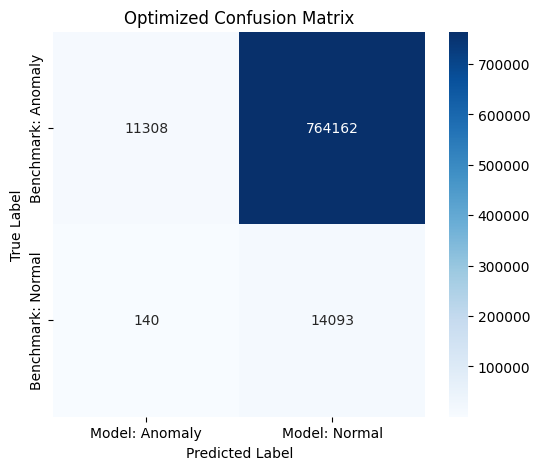

True Positives (TP): 11308
False Positives (FP): 140
False Negatives (FN): 764162
True Negatives (TN): 14093


In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the full set of timestamps
benchmark_set = set(benchmark_anomaly_dates)
model_set = set(anomaly_dates)
all_set = set(combined_test_dates)

tp = len(model_set & benchmark_set)  
fp = len(model_set - benchmark_set)  
fn = len(benchmark_set - model_set)  
tn = len(all_set - (benchmark_set | model_set))  

cm = np.array([[tp, fn], [fp, tn]])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Model: Anomaly", "Model: Normal"],
            yticklabels=["Benchmark: Anomaly", "Benchmark: Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized Confusion Matrix")
plt.show()

# Print values
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

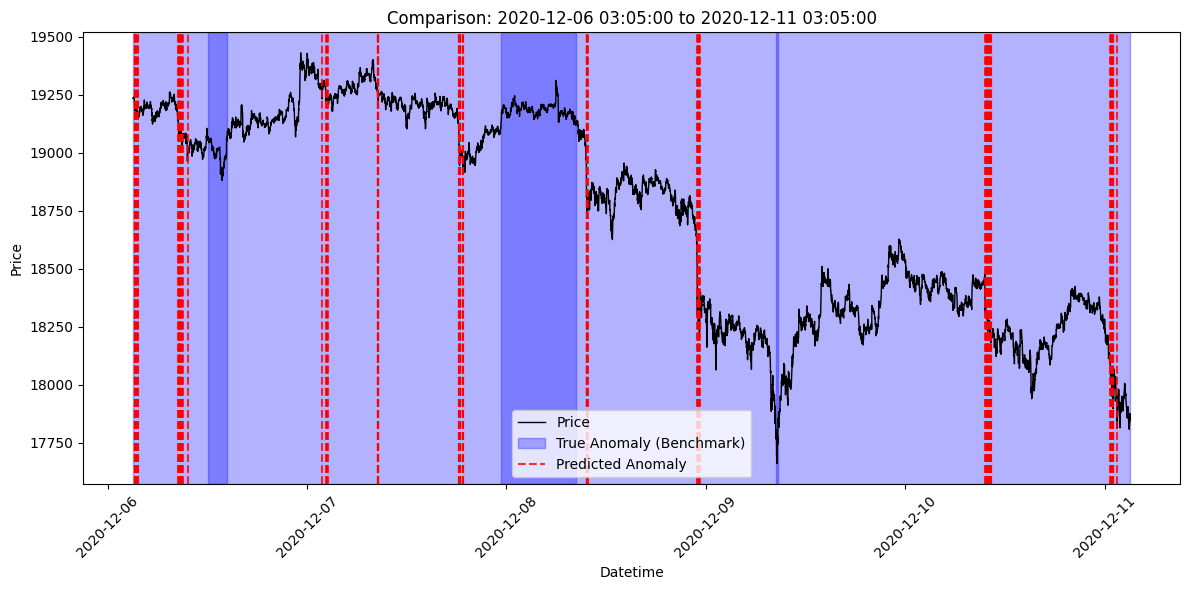

In [103]:
plot_true_vs_predicted(
    unscaled_prices, 
    combined_test_dates, 
    benchmark_extreme_regions, 
    anomaly_dates, 
    num_windows=3, 
    window_duration="5D"
)

In [69]:
print(len(benchmark_anomaly_dates))

11825


In [95]:
print(type(combined_test_dates[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
